# Stereo Vision Pipeline for Disparity Map Estimation

This notebook describes the complete pipeline for computing disparity maps using a stereo camera system.
The goal is to improve the quality and robustness of disparity estimation by refining each processing step,
including camera calibration, image rectification, distortion correction, and post-processing.

The pipeline consists of the following steps:

1. Disparity map computation using StereoSGBM
2. Disparity map computation with hole-filling post-processing
3. Improved camera calibration (estimation of intrinsic parameters and distortion coefficients)
4. Verification and tuning of distortion correction using calibration parameters
5. Image rectification and undistortion
6. Disparity map computation using rectified and undistorted images

Each step is explained below with its purpose and role in the overall pipeline.

## 1. Disparity Map Computation Using StereoSGBM

In this step, a disparity map is computed using the Stereo Semi-Global Block Matching (StereoSGBM) algorithm.
StereoSGBM estimates pixel-wise disparities by matching corresponding points between left and right images
while considering smoothness constraints along multiple directions.

This step serves as a baseline disparity estimation using raw stereo images,
without applying any distortion correction or rectification.
As a result, noise, mismatches, and invalid regions may appear in the disparity map.


Mounted at /content/drive


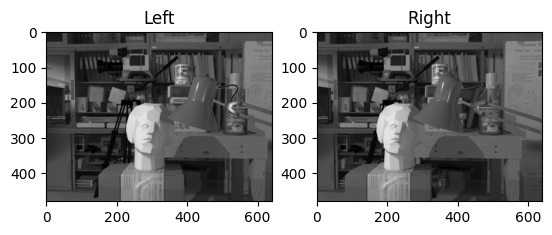

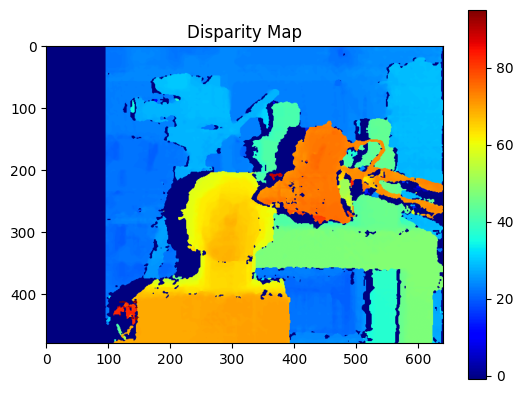

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

left = cv2.imread("/content/drive/MyDrive/Amazon project/img/image_from_left_camera.png", cv2.IMREAD_GRAYSCALE)
right = cv2.imread("/content/drive/MyDrive/Amazon project/img/image_from_right_camera.png", cv2.IMREAD_GRAYSCALE)


plt.subplot(1,2,1); plt.imshow(left, cmap='gray'); plt.title("Left")
plt.subplot(1,2,2); plt.imshow(right, cmap='gray'); plt.title("Right")
plt.show()

#-----------------------create disparity map--------------------------
numDisparities = 16 * 6
blockSize = 5

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=8 * blockSize**2,
    P2=32 * blockSize**2,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=31
)

disparity = stereo.compute(left,right).astype(np.float32) / 16.0
# disparity[disparity < 0] = np.nan

plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.title("Disparity Map")
plt.show()

## 1.2 Disparity Map Computation with Hole-Filling

The initial disparity map often contains holes (invalid or missing disparity values),
especially in textureless regions or near occlusions.

To address this issue, a hole-filling post-processing step is applied.
This process interpolates missing disparity values using neighboring valid pixels,
resulting in a more continuous and visually stable disparity map.

This step improves the usability of the disparity map for downstream tasks
such as depth estimation and 3D reconstruction.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


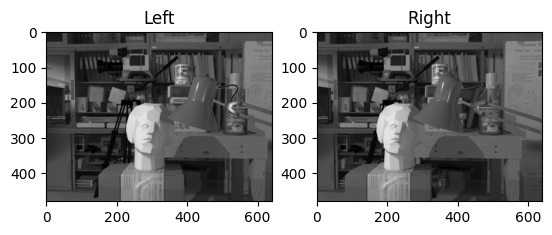

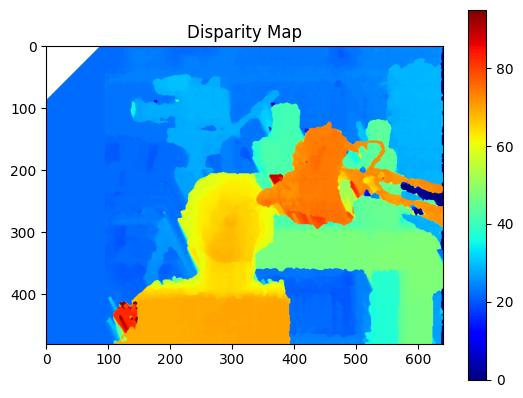

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

left = cv2.imread("/content/drive/MyDrive/Amazon project/img/image_from_left_camera.png", cv2.IMREAD_GRAYSCALE)
right = cv2.imread("/content/drive/MyDrive/Amazon project/img/image_from_right_camera.png", cv2.IMREAD_GRAYSCALE)


plt.subplot(1,2,1); plt.imshow(left, cmap='gray'); plt.title("Left")
plt.subplot(1,2,2); plt.imshow(right, cmap='gray'); plt.title("Right")
plt.show()

#-----------------------create disparity map--------------------------
numDisparities = 16 * 6
blockSize = 5

stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=numDisparities,
    blockSize=blockSize,
    P1=8 * blockSize**2,
    P2=32 * blockSize**2,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=31
)

disp = stereo.compute(left,right).astype(np.float32) / 16.0
disp[disp < 0] = np.nan

def fill_holes_local(disp, window=3, max_iter=5):
    """
    disp: np.ndarray, NaN
    window: 探索する周囲ピクセルの幅 (window x window)
    max_iter: 繰り返し回数
    """
    disp_filled = disp.copy()
    h, w = disp.shape
    r = window // 2

    for _ in range(max_iter):
        nan_mask = np.isnan(disp_filled)
        if not nan_mask.any():
            break

        ys, xs = np.where(nan_mask)
        for y, x in zip(ys, xs):
            y0, y1 = max(0, y - r), min(h, y + r + 1)
            x0, x1 = max(0, x - r), min(w, x + r + 1)
            patch = disp_filled[y0:y1, x0:x1]
            valid = patch[~np.isnan(patch)]
            if valid.size > 0:
                disp_filled[y, x] = np.median(valid)

    return disp_filled
disp_filled = fill_holes_local(disp, window=3, max_iter=5)


plt.imshow(disp_filled, cmap='jet')
plt.colorbar()
plt.title("Disparity Map")
plt.show()

## 2. Camera Calibration (Overview)

Camera calibration is the process of estimating the geometric parameters of a camera
that describe how 3D points in the real world are projected onto the 2D image plane.

In general, camera calibration estimates the following parameters:

- **Intrinsic parameters**: focal length, principal point, and skew
- **Distortion coefficients**: radial and tangential lens distortions

These parameters are typically estimated by observing a known calibration pattern,
such as a checkerboard, from multiple viewpoints.
By minimizing the reprojection error between the observed image points
and the projected 3D points of the pattern, the camera parameters are optimized.

Accurate camera calibration is a fundamental prerequisite for stereo vision tasks.
Without proper calibration, image distortion and geometric inconsistencies
can significantly degrade the accuracy of rectification and disparity estimation.


In [3]:
import cv2
import numpy as np
import glob
import os
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

CHECKERBOARD = (7, 7)
SQUARE_SIZE = 1.41

IMG_DIR = "/content/drive/MyDrive/Amazon project/chess"


objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SQUARE_SIZE

objpoints = []  # 3Dポイント
imgpoints = []  # 2Dポイント


jpg_files = glob.glob(os.path.join(IMG_DIR, "*.jpg"))
print(f"Found {len(jpg_files)} JPG files.")

if len(jpg_files) == 0:
    print("JPGが1枚も見つかりません。パスを確認してください。")

for fname in jpg_files:

    img = cv2.imread(fname)
    if img is None:
        print(f" Failed to read: {fname}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

    if ret:
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        objpoints.append(objp)
        imgpoints.append(corners2)

        print(f" Detected corners: {os.path.basename(fname)}")
    else:
        print(f" Failed: {os.path.basename(fname)}")



ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

print("\n===== Calibration Results =====")
print("Intrinsic Matrix K:\n", K)
print("Distortion Coefficients:\n", dist)
print("Reprojection Error:", ret)


total_error = 0
errors = []

for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    errors.append(error)
    total_error += error

mean_error = total_error / len(objpoints)

print("\n=====  Evaluation =====")
for i, e in enumerate(errors):
    print(f"Image {i+1}: {e:.4f} px")

print(f"\nMean Reprojection Error: {mean_error:.4f} px")

np.save("intrinsic.npy", K)
np.save("distortion.npy", dist)

print("\nSaved: intrinsic.npy / distortion.npy")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 57 JPG files.
 Detected corners: LINE_ALBUM_1212_251212_2.jpg
 Detected corners: LINE_ALBUM_1212_251212_1.jpg
 Detected corners: LINE_ALBUM_1212_251212_6.jpg
 Detected corners: LINE_ALBUM_1212_251212_3.jpg
 Detected corners: LINE_ALBUM_1212_251212_5.jpg
 Detected corners: LINE_ALBUM_1212_251212_8.jpg
 Detected corners: LINE_ALBUM_1212_251212_4.jpg
 Detected corners: LINE_ALBUM_1212_251212_9.jpg
 Detected corners: LINE_ALBUM_1212_251212_11.jpg
 Detected corners: LINE_ALBUM_1212_251212_10.jpg
 Detected corners: LINE_ALBUM_1212_251212_13.jpg
 Detected corners: LINE_ALBUM_1212_251212_12.jpg
 Detected corners: LINE_ALBUM_1212_251212_17.jpg
 Detected corners: LINE_ALBUM_1212_251212_16.jpg
 Detected corners: LINE_ALBUM_1212_251212_14.jpg
 Detected corners: LINE_ALBUM_1212_251212_15.jpg
 Detected corners: LINE_ALBUM_1212_251212_22.jpg
 Detected corners: LINE_AL

## 2.1. Verification of Checkerboard Corner Detection

Accurate detection of checkerboard corners is a fundamental prerequisite
for reliable camera calibration.

In this step, detected corner points are visualized on the calibration images
to verify the following:

- All expected corners are successfully detected
- Corner positions align correctly with the checkerboard pattern
- No missing or falsely detected corners are present

This verification helps ensure that only high-quality feature points
are used for camera calibration, preventing large reprojection errors
in subsequent steps.


In [ ]:
import cv2
import numpy as np
import glob
import os
from google.colab import drive
from google.colab.patches import cv2_imshow

# Google Driveマウント
drive.mount('/content/drive')

# ===================================================
# パラメータ設定
# ===================================================
CHECKERBOARD = (7, 7)  # チェスボードの行・列
SQUARE_SIZE = 1.41     # 1マスのサイズ（任意単位）

IMG_DIR = "/content/drive/MyDrive/Amazon project/chess"

# チェスボードの3D座標（Z=0平面）
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= SQUARE_SIZE

# 保存用リスト
objpoints = []  # 3Dポイント
imgpoints = []  # 2Dポイント

# ===================================================
# 画像読み込み
# ===================================================
jpg_files = glob.glob(os.path.join(IMG_DIR, "*.jpg"))
print(f"Found {len(jpg_files)} JPG files.")

if len(jpg_files) == 0:
    print("JPGが1枚も見つかりません。パスを確認してください。")

# ===================================================
# 角点検出と可視化
# ===================================================
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname in jpg_files:

    img = cv2.imread(fname)
    if img is None:
        print(f" Failed to read: {fname}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)

    if ret:
        # サブピクセル精度で補正
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        objpoints.append(objp)
        imgpoints.append(corners2)

        # 可視化
        vis_img = img.copy()
        cv2.drawChessboardCorners(vis_img, CHECKERBOARD, corners2, ret)
        print(f" Detected corners: {os.path.basename(fname)}")
        cv2_imshow(vis_img)  # Colabで表示
        cv2.waitKey(500)     # 0.5秒表示
    else:
        print(f" Failed: {os.path.basename(fname)}")

cv2.destroyAllWindows()

# ===================================================
# カメラキャリブレーション
# ===================================================
if len(objpoints) > 0:
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None
    )

    print("\n===== Calibration Results =====")
    print("Intrinsic Matrix K:\n", K)
    print("Distortion Coefficients:\n", dist)
    print("Reprojection Error:", ret)

    # 再投影誤差計算
    total_error = 0
    errors = []

    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        errors.append(error)
        total_error += error

    mean_error = total_error / len(objpoints)

    print("\n=====  Evaluation =====")
    for i, e in enumerate(errors):
        print(f"Image {i+1}: {e:.4f} px")
    print(f"\nMean Reprojection Error: {mean_error:.4f} px")

    # npyとして保存
    np.save("intrinsic.npy", K)
    np.save("distortion.npy", dist)
    print("\nSaved: intrinsic.npy / distortion.npy")
else:
    print("キャリブレーション用の有効な画像がありません。")